In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import os

# --- Setup Output Directory ---
script_dir = os.getcwd() 
OUTPUT_DIR = os.path.join(script_dir, "eda_results")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
REPORT_FILE = os.path.join(OUTPUT_DIR, "eda_report.txt")

# Clear the report file if it exists
if os.path.exists(REPORT_FILE):
    os.remove(REPORT_FILE)

def write_to_report(content, title=""):
    """Appends content to the report file."""
    with open(REPORT_FILE, 'a', encoding='utf-8') as f:
        if title:
            f.write(f"--- {title} ---\n")
        f.write(str(content) + "\n\n")

# --- 1. Load the Data ---
def load_data(file_path):
    """Loads a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_entity_set(file_path):
    """Loads the entity set from a text file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

# Define data paths (assuming a 'data' subfolder)
df_text = pd.DataFrame(load_data(os.path.join(script_dir, 'data', 'medxpertqa_text_test.json')))
df_mm = pd.DataFrame(load_data(os.path.join(script_dir, 'data', 'medxpertqa_mm_test.json')))

# You could combine them if desired, adding a 'type' column
df_text['type'] = 'text'
df_mm['type'] = 'multimodal'
df_all = pd.concat([df_text, df_mm], ignore_index=True)

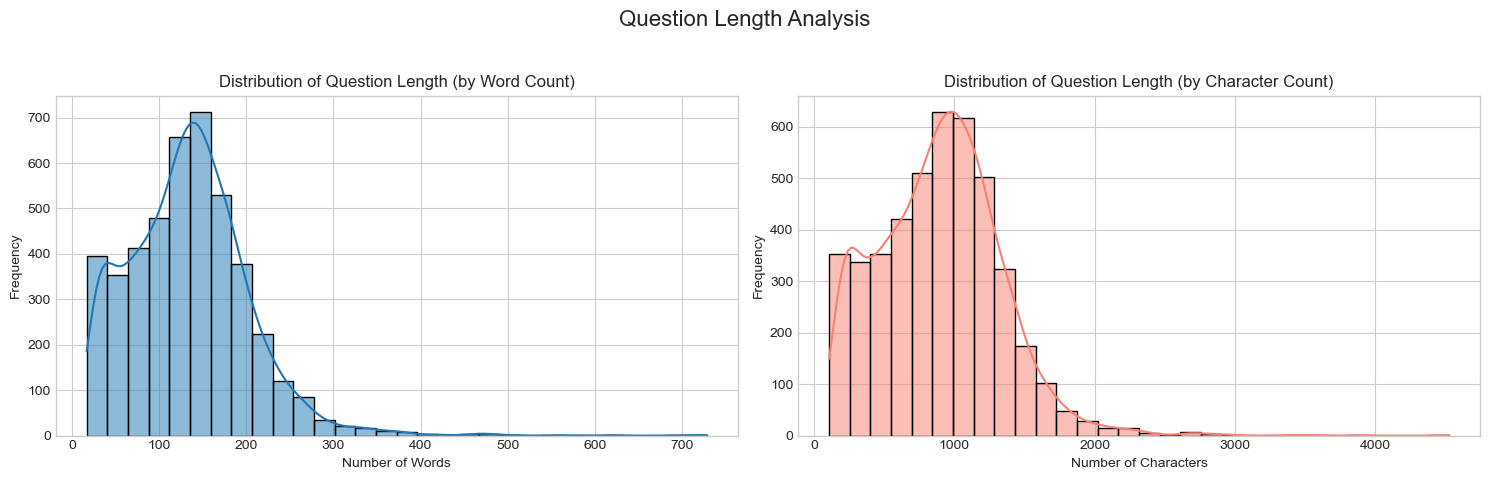

In [4]:
write_to_report("EDA Survey for MedXpertQA Dataset", title="START OF REPORT")

# --- 2. Basic Data and Sentence Analysis ---
report_title = "2. Basic Data and Sentence Analysis"
basic_stats = (
    f"Number of text samples: {len(df_text)}\n"
    f"Number of multimodal samples: {len(df_mm)}\n"
    f"Total number of samples: {len(df_all)}"
)
write_to_report(basic_stats, title=report_title)

df_all['question_word_count'] = df_all['question'].apply(lambda x: len(x.split()))
df_all['question_char_count'] = df_all['question'].apply(len)
write_to_report(df_all[['question_word_count', 'question_char_count']].describe(), title="Question Length Statistics")

# Plot and save sentence length distributions
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_all['question_word_count'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Question Length (by Word Count)')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
sns.histplot(df_all['question_char_count'], bins=30, ax=axes[1], kde=True, color='salmon')
axes[1].set_title('Distribution of Question Length (by Character Count)')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')
plt.suptitle('Question Length Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

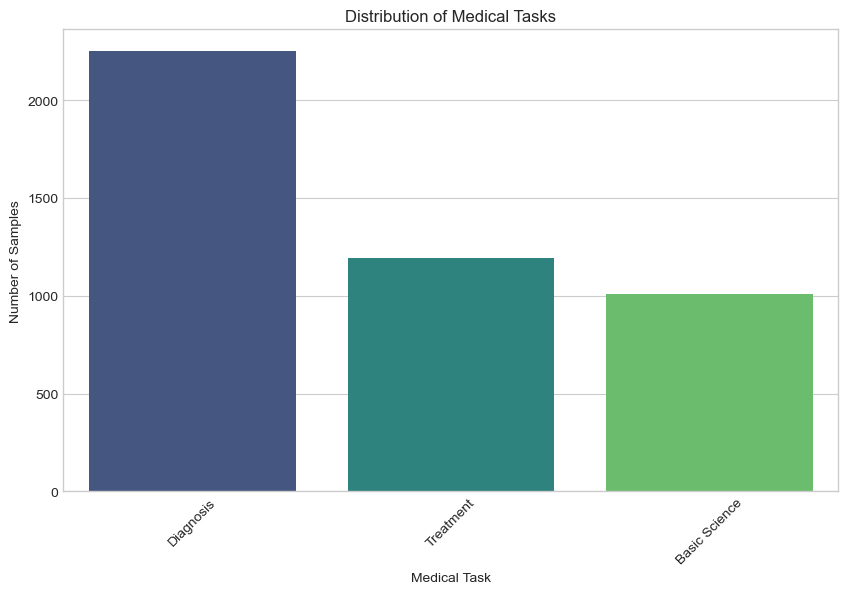

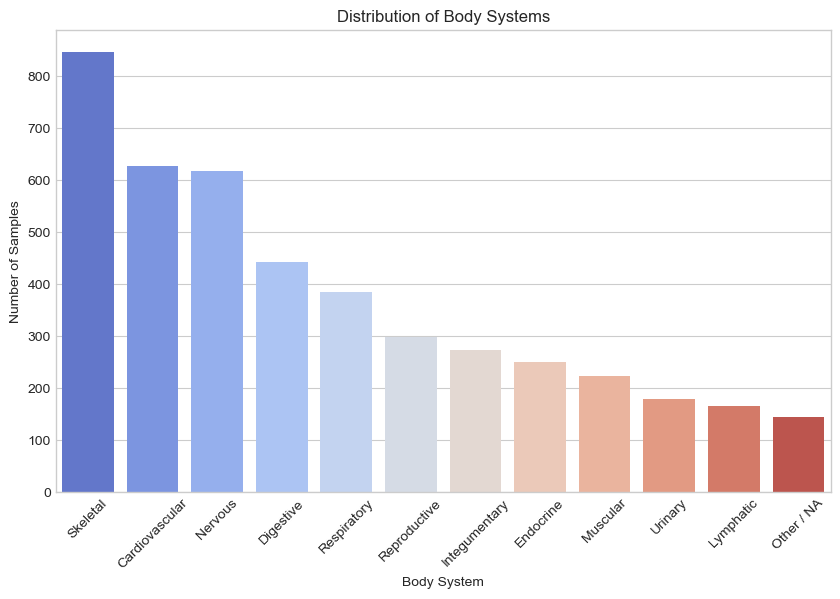

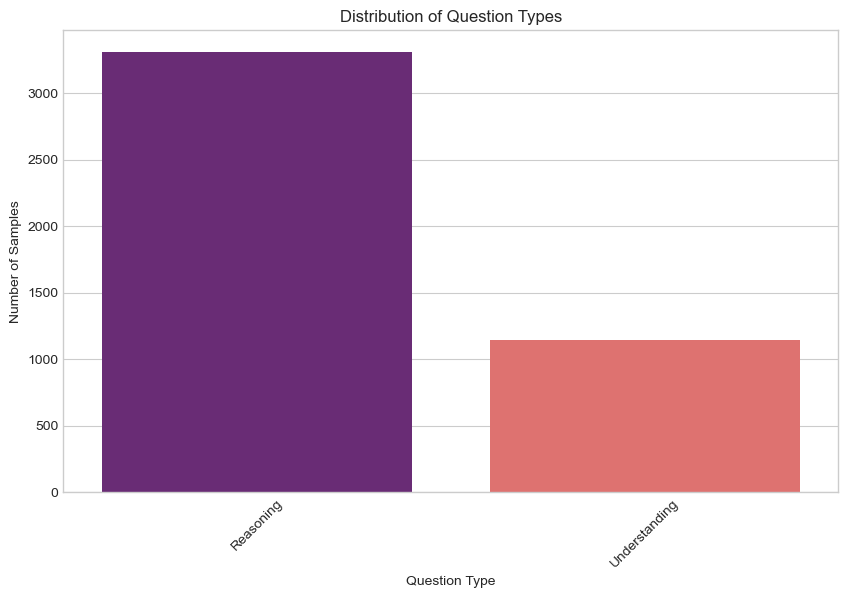

In [7]:
# --- 3. Categorical Label Analysis (`sent_label`) ---
report_title = "3. Categorical Label Analysis"
task_counts = df_all['medical_task'].value_counts()
system_counts = df_all['body_system'].value_counts()
type_counts = df_all['question_type'].value_counts()
write_to_report(task_counts, title=report_title)

# Plot and save task distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=task_counts.index, y=task_counts.values, hue=task_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Medical Tasks')
plt.xlabel('Medical Task')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Plot and save body system distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=system_counts.index, y=system_counts.values, hue=system_counts.index, palette='coolwarm', legend=False)
plt.title('Distribution of Body Systems')
plt.xlabel('Body System')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Plot and save question type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index, palette='magma', legend=False)
plt.title('Distribution of Question Types')
plt.xlabel('Question Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Distribution of Correct Answer Labels
label_counts = df_all['label'].value_counts().sort_index()
write_to_report(label_counts, title="Distribution of Correct Answer Labels")

df_all['num_options'] = df_all['options'].apply(lambda x: len(x))
write_to_report(df_all['num_options'].describe(), title="Statistics for Number of Options per Question")

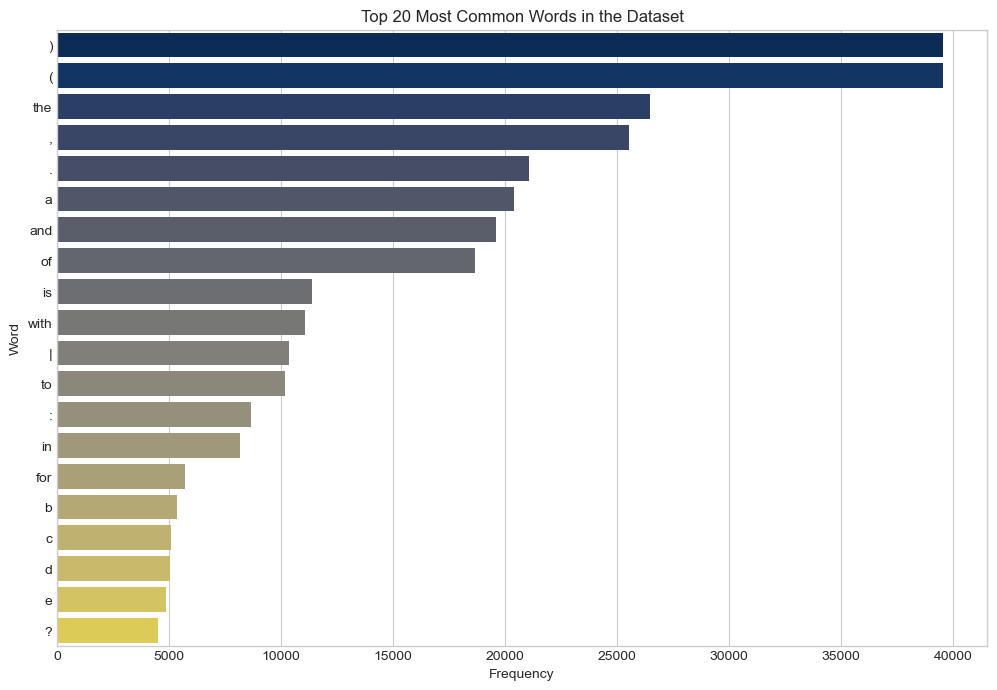

In [11]:
# --- Vocabulary and Word Frequency Analysis ---
def get_all_text(row):
    question_text = row['question']
    options_text = ' '.join(row['options'].values())
    return question_text + ' ' + options_text

report_title = "Vocabulary and Word Frequency Analysis"
corpus = ' '.join(df_all.apply(get_all_text, axis=1)).lower()
words = word_tokenize(corpus)
word_counts = Counter(words)
vocab_stats = (
    f"Total number of words (tokens): {len(words)}\n"
    f"Vocabulary size (unique words): {len(word_counts)}"
)
write_to_report(vocab_stats, title=report_title)

most_common_words = word_counts.most_common(20)
mcw_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
write_to_report(mcw_df, title="20 Most Common Words")

# Plot and save the frequency of the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=mcw_df, hue='word', palette='cividis', legend=False)
plt.title('Top 20 Most Common Words in the Dataset')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.savefig(os.path.join(OUTPUT_DIR, 'top_20_words.png'), bbox_inches='tight')
plt.show()

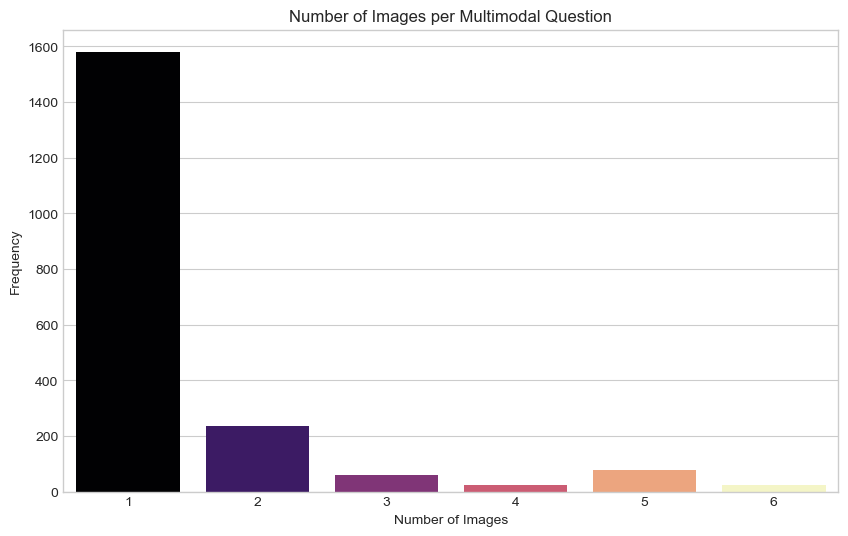

In [ ]:
# Section for Multimodality
df_mm['num_images'] = df_mm['images'].apply(lambda x: len(x) if isinstance(x, list) else 0)
write_to_report(df_mm['num_images'].describe(), title="Statistics for Number of Images per Question (MM set)")

# Plotting the distribution of the number of images per question
plt.figure(figsize=(10, 6))
sns.countplot(x='num_images', data=df_mm, hue='num_images', palette='magma', legend=False)
plt.title('Number of Images per Multimodal Question')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.show()